# HALHF Particle Transverse Wake Instability Stages Tests

For simulating the HALHF linac with interstages. The simulation employs the particle transverse wake instability model.

Ben Chen, 6 October 2023, University of Oslo

## Import ABEL framework and required classes

In [1]:
import sys
sys.path.append('../')
from abel import *
import numpy as np

from scipy.constants import c, e, m_e, epsilon_0 as eps0
from abel.utilities.relativity import energy2gamma

# Enable the widget backend for interactive plots
%matplotlib widget

# Sets the seed for the pseudo-random number generator in Python to obtain the same sequence of random numbers.
np.random.seed(42) 

[INFO    ] csr.py: module PYFFTW is not installed. Install it to speed up calculation.
[INFO    ] csr.py: module NUMEXPR is not installed. Install it to speed up calculation


initializing ocelot...
import: module PYFFTW is not installed. Install it to speed up calculation
import: module NUMEXPR is not installed. Install it to speed up calculation


## Settings and definitions

In [2]:
# Determines whether the results of the tracking should be overwritten.
overwrite = False

# Determines whether to use interstages in the tracking. Currently also need to comment out some lines in interstage_basic.py.
use_interstages = False

# Flag for enable interstage drive beam jitter
enable_driver_jitter = True

# Number of stages in the linac.
num_stages = 16

# Can use 2D parallel tracking to track x and y motion (faster) separately if no particle loss is expected.
parallel_track_2D = False

# Determines whether to save plots
save_plots = True

# Determines the DPI value the figures are saved to
save_fig_dpi = 600

# Set the default display DPI
plt.rcParams['figure.dpi'] = 100

# Set default font sizes for figures
import matplotlib.pylab as pylab
params = {
    #'figure.figsize': (15, 5),
    'axes.titlesize': 'xx-large',
    'axes.labelsize': 'x-large',
    'xtick.labelsize': 'large',
    'ytick.labelsize': 'large',
    'legend.fontsize': 'large'
}
pylab.rcParams.update(params)

# Set the figure size to fit within the notebook cell
#plt.rcParams['figure.figsize'] = [.1, .1]  # Adjust these values as needed

# Set various paths
notebook_name = 'HALHF_prtcl_instability_stage_tests'
path_sep = os.sep
current_dir = os.path.abspath('')  # Get the current file's directory name.
diag_path = current_dir + path_sep + 'run_data' + path_sep + notebook_name + path_sep

## Define the input beams
Parameters based on "A hybrid, asymmetric, linear Higgs factory based on plasma-wakefield and radio-frequency acceleration" 23 Aug 2023.

In [3]:
############# Define drive beam #############
driver = SourceBasic()
driver.bunch_length = 42.0e-6  # [m]
driver.num_particles = 10000
driver.charge = -e * 2.7e10  # [C]
driver.energy = 31.25e9  # [eV]
driver_gamma = energy2gamma(driver.energy)
driver.rel_energy_spread = 0.01*0
driver.z_offset = 334.0e-6 # [m]
driver.emit_nx, driver.emit_ny = 10.0e-6, 10.0e-6  # [m rad]
driver.beta_x, driver.beta_y = 30.0e-3, 30.0e-3  # [m]
driver_sigma_x = np.sqrt(driver.emit_nx/driver_gamma*driver.beta_x)  # [m]
driver_sigma_y = np.sqrt(driver.emit_ny/driver_gamma*driver.beta_y)  # [m]

if enable_driver_jitter is True:
    #driver.jitter.x = driver_sigma_x*0.1  # [m], std
    #driver.jitter.y = driver_sigma_y*0.03  # [m], std
    driver.jitter.x = 100e-9  # [m], std
    driver.jitter.y = 100e-9  # [m], std

driver.symmetrize = True
#driver.wallplug_efficiency = 0.19


############# Define main beam #############
#main = SourceTrapezoid()
#main.current_head = 13.881e3  # [A]
#main.bunch_length = 58e-6  # [m], total beam length.
##main.bunch_length = 1.0e10*e*c/(2*np.pi*main.current_head)  # [m], total beam length.
#main.z_offset = main.bunch_length/2  # [m]

main = SourceBasic()
main.bunch_length = 18.0e-06  # [m], rms.

main.num_particles = 6000
main.charge = -e * 1.0e10  # [C]

# Energy parameters
main.energy = 5e9  # [eV]
main_gamma = energy2gamma(main.energy)
main.rel_energy_spread = 0.005  # Relative rms energy spread.
#main.rel_energy_spread = 0.2  # Relative rms energy spread.

# Emittances
main.emit_nx = 160.0e-6  # [m rad]
main.emit_ny = 0.56e-6  # [m rad]

# Beta functions
main.beta_x = beta_matched(7.0e21, main.energy)  # [m]
main.beta_y = beta_matched(7.0e21, main.energy)  # [m]
main_sigma_x = np.sqrt(main.emit_nx/main_gamma*main.beta_x)  # [m]
main_sigma_y = np.sqrt(main.emit_ny/main_gamma*main.beta_y)  # [m]

# Offsets
main.x_offset = main_sigma_x*0.1  # [m]
main.y_offset = main_sigma_y*0.1  # [m]
#main.x_offset = 100e-9  # [m]
#main.y_offset = 100e-9  # [m]
main.z_offset = 0.00  # [m] # Standard value

# Other
main.symmetrize = True
#main.wallplug_efficiency = 0.1


## Define the linac

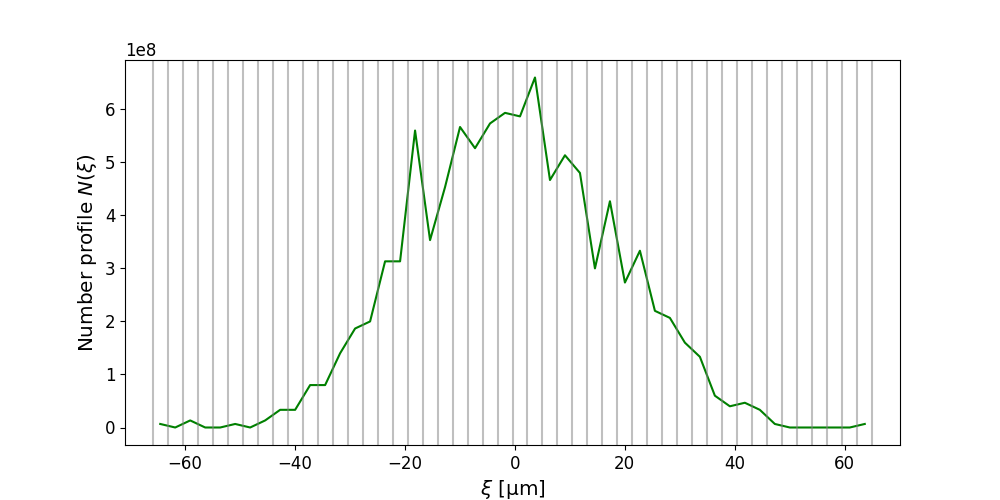

In [4]:
############# Define the first stage #############
first_stage = StagePrtclTransWakeInstability()
first_stage.time_step_mod = 0.04
first_stage.length = 2.5                                # [m], standard value
first_stage.nom_energy_gain = 6.4e9*first_stage.length  # [eV]
first_stage.plasma_density = 7.0e21                     # [m^-3]
first_stage.driver_source = driver
first_stage.main_source = main
drive_beam = first_stage.driver_source.track()  # Convert a Source object to a Beam object.
main_beam = first_stage.main_source.track()     # Convert a Source object to a Beam object.
first_stage.drive_beam = drive_beam
first_stage.main_beam = main_beam
first_stage.interstages_enabled = use_interstages
first_stage.parallel_track_2D = parallel_track_2D
first_stage.diag_path = diag_path


# ========== Beam slice parameters ==========
main_beam_roi = np.max(np.abs(main_beam.zs()))/main_beam.bunch_length()*1.5  # Specifies the region of interest in units of main beam sigma_z (rms bunch length).
first_stage.main_beam_roi = main_beam_roi
#cut_off = first_stage.main_beam_roi*main.bunch_length
#first_stage.beam_length_roi = 2*cut_off  # [m] total bunch/beam length.  old name: tot_beam_length

# Freedman–Diaconis rule for determining the beam slice thickness
num_beam_slice = first_stage.FD_rule_num_slice()
first_stage.num_beam_slice = num_beam_slice

# Number profile N(z). Dimensionless, same as dN/dz with each bin multiplied with the width of the slices.
main_num_profile, z0_slices = first_stage.longitudinal_number_distribution(beam=first_stage.main_beam, make_plot=True)  # uniform_bins=False allows for thicker slices towards beam head.
first_stage.main_num_profile = main_num_profile
first_stage.z_slices = z0_slices
#num_beam_slice = len(z0_slices)
#first_stage.num_beam_slice = num_beam_slice

#driver_num_profile, zs_driver_cut = first_stage.longitudinal_number_distribution(beam=first_stage.drive_beam)
#first_stage.driver_num_profile = driver_num_profile
#first_stage.zs_driver_cut = zs_driver_cut

# Initial main beam slice x-offsets, energies and x'-offsets
#first_stage.x_slices_main = first_stage.particles2slices(beam=first_stage.main_beam, beam_quant=first_stage.main_beam.xs(), z_slices=first_stage.z_slices, make_plot=False)
#first_stage.xp_slices_main = first_stage.particles2slices(beam=first_stage.main_beam, beam_quant=first_stage.main_beam.xps(), z_slices=first_stage.z_slices, make_plot=False)
#first_stage.y_slices_main = first_stage.particles2slices(beam=first_stage.main_beam, beam_quant=first_stage.main_beam.ys(), z_slices=first_stage.z_slices, make_plot=False)
#first_stage.yp_slices_main = first_stage.particles2slices(beam=first_stage.main_beam, beam_quant=first_stage.main_beam.yps(), z_slices=first_stage.z_slices, make_plot=False)
#first_stage.energy_slices_main = first_stage.particles2slices(beam=first_stage.main_beam, beam_quant=first_stage.main_beam.Es(), z_slices=first_stage.z_slices, make_plot=False)



############# Define the other stages #############
stage = StagePrtclTransWakeInstability()
stage.time_step_mod = first_stage.time_step_mod
stage.length = 5.0                          # [m]
stage.nom_energy_gain = 6.4e9*stage.length  # [eV]
stage.plasma_density = 7.0e21               # [m^-3]
stage.driver_source = driver
stage.main_source = main
stage.drive_beam = drive_beam
stage.main_beam = main_beam
stage.interstages_enabled = use_interstages
stage.parallel_track_2D = parallel_track_2D
stage.diag_path = current_dir + path_sep + 'run_data' + path_sep + notebook_name + path_sep


# ========== Beam slice parameters ==========
stage.main_beam_roi = main_beam_roi  # Specifies the region of interest in units of main beam sigma_z (rms bunch length).
#cut_off = stage.main_beam_roi*main.bunch_length
#stage.beam_length_roi = 2*cut_off  # [m] total bunch/beam length.  old name: tot_beam_length
#stage.num_uniform_beam_slice = num_uniform_beam_slice
stage.num_beam_slice = num_beam_slice

# Number profile N(z). Dimensionless, same as dN/dz with each bin multiplied with the width of the slices.
stage.main_num_profile = main_num_profile
stage.z_slices = z0_slices
#driver_num_profile, zs_driver_cut = stage.longitudinal_number_distribution(beam=stage.drive_beam)
#stage.driver_num_profile = driver_num_profile
#stage.zs_driver_cut = zs_driver_cut

# Initial main beam slice x-offsets, energies and x'-offsets
#stage.x_slices_main = first_stage.x_slices_main
#stage.xp_slices_main = first_stage.xp_slices_main
#stage.y_slices_main = first_stage.y_slices_main
#stage.yp_slices_main = first_stage.yp_slices_main
#stage.energy_slices_main = first_stage.energy_slices_main



############# Define interstages #############
if use_interstages is True:
    interstage = InterstageBasic()
    interstage.beta0 = lambda energy: stage.matched_beta_function(energy)
    interstage.dipole_length = lambda energy: 1 * np.sqrt(energy/10e9)  # [m(eV)], energy-dependent length
    interstage.dipole_field = 0.5  # [T]  (0-2)T
    #interstage.dipole_field = 1.0  # [T]  (0-2)T
else:
    interstage = InterstageNull()
first_stage.interstage_dipole_field = interstage.dipole_field
stage.interstage_dipole_field = interstage.dipole_field


############# Define linac #############
linac = Linac(source=main, first_stage=first_stage, stage=stage, interstage=interstage, num_stages=num_stages)

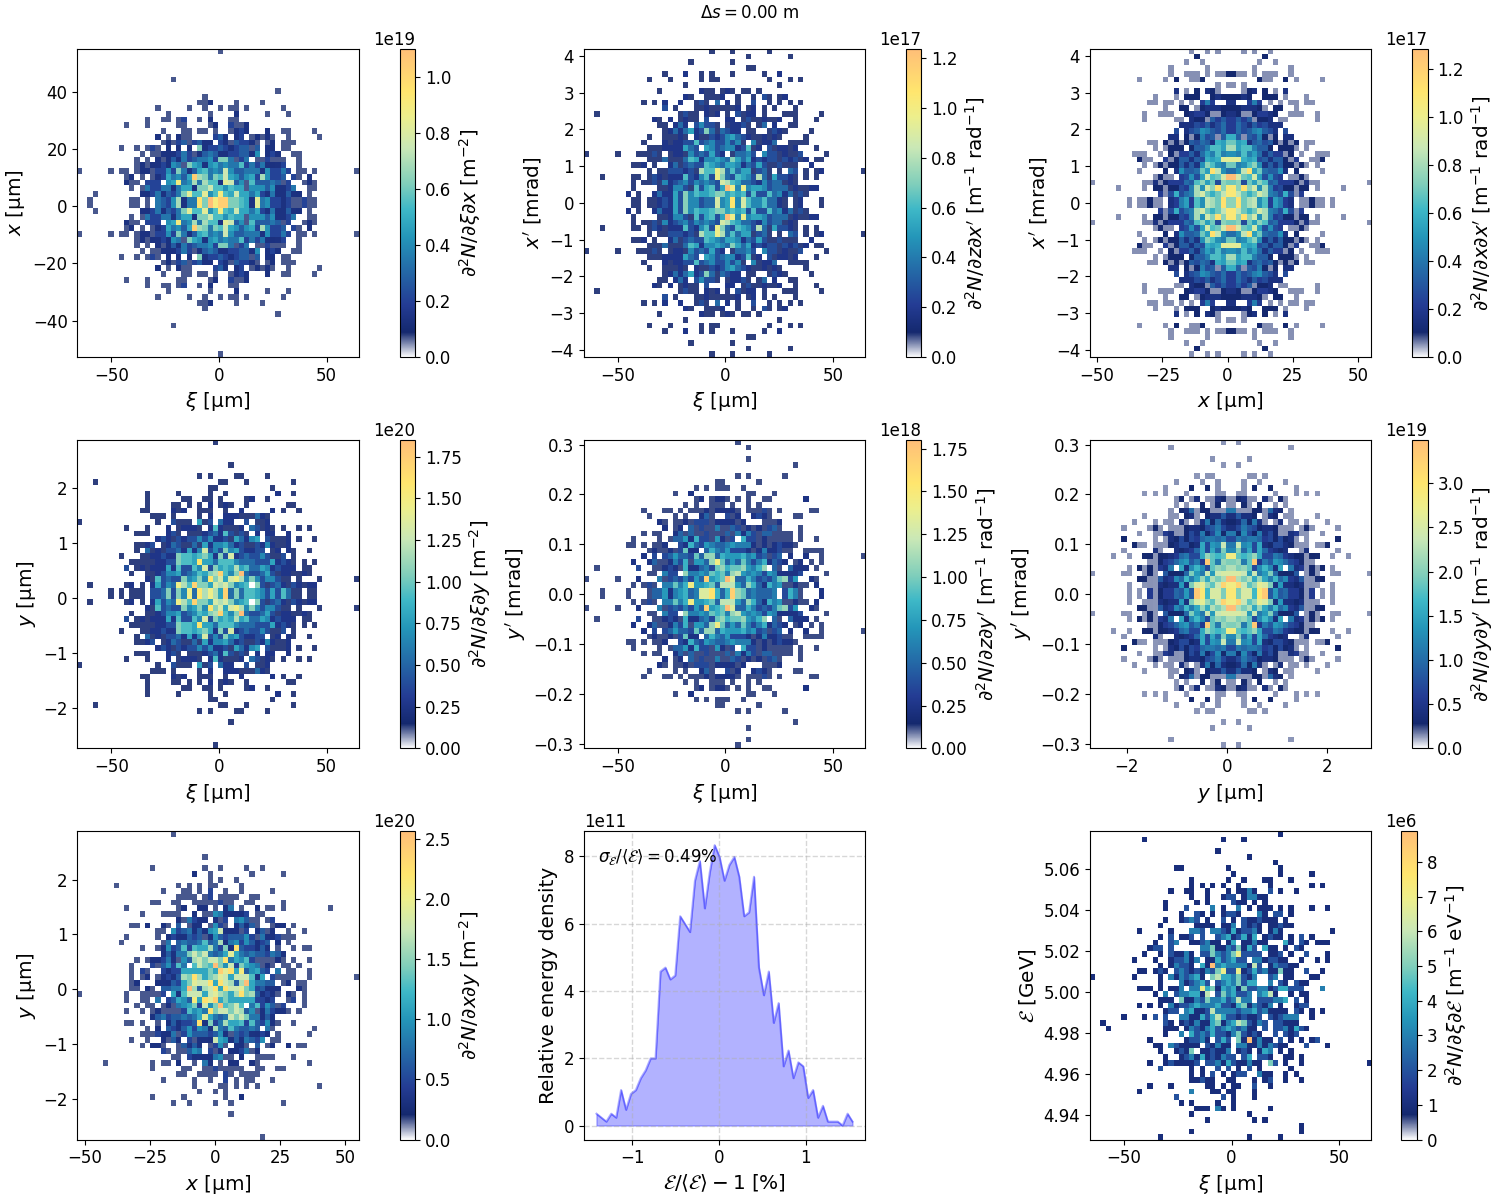

In [5]:
#first_stage.scatter_diags(beam=first_stage.main_beam, plot_centroids=False, n_th_particle=1)
first_stage.density_map_diags(beam=first_stage.main_beam, plot_centroids=False)

## Calculate input longitudinal field, plasma bubble radius and longitudinal number profile with Wake-T

In [6]:
# Define a Wake-T stage
stage_wakeT = StageWakeT()
stage_wakeT.driver_source = driver
k_beta = k_p(stage.plasma_density)/np.sqrt(2*min(main_beam.gamma(),drive_beam.gamma()/2))
lambda_betatron = (2*np.pi/k_beta)
stage_wakeT.length = lambda_betatron/10  # [m]
stage_wakeT.plasma_density = stage.plasma_density  # [m^-3]
#stage_wakeT.box_min_z = -100.0e-6
#stage_wakeT.box_max_z = 500.0e-6

#stage_wakeT.box_max_z = driver0.z_offset() + 3 * blowout_radius(self.plasma_density, driver0.peak_current())

#stage_wakeT.box_size_r = 240.5e-6
stage_wakeT.opmd_diag = True  # Set to True for saving simulation results.
stage_wakeT.diag_dir = stage.diag_path + 'wake_t'

# Run the Wake-T stage
beam_copy = copy.deepcopy(first_stage.main_beam)
beam_wakeT = stage_wakeT.track(beam_copy)

# Read the simulation data
path = stage_wakeT.diag_dir + path_sep + 'hdf5'
ts = OpenPMDTimeSeries(path)

Plasma stage: 100%|█████████████████████████████████████████████| 0.005583/0.005583 m [00:00]


### Extract data

In [7]:
iteration = 0
dump_time = ts.t[iteration]


# Extract macroparticle coordinates
xs_main, zs_main, weights_main = ts.get_particle(species='beam', iteration=iteration, var_list=['x', 'z', 'w'], plot=False)
xs_driver, zs_driver, weights_driver = ts.get_particle(species='driver', iteration=iteration, var_list=['x', 'z', 'w'], plot=False)
zs_beams = np.append(zs_driver, zs_main)
xs_beams = np.append(xs_driver, xs_main)


# Extract transverse fields
Ex, info_Ex = ts.get_field(field='E', coord='x', iteration=iteration, plot=False)
By, info_By = ts.get_field(field='B', coord='y', iteration=iteration, plot=False)
Ex_cBy = Ex - c*By
zs_Ex = info_Ex.z
rs_Ex = info_Ex.r


# Extract longitudinal E-field
Ez_wakeT, info_Ez = ts.get_field(field='E', coord='z', iteration=iteration, plot=False)
#dir(info_Ez)
zs_Ez_wakeT = info_Ez.z
rs_Ez = info_Ez.r
# Extract axial longitudinal E-field
Ez_axis_wakeT = Ez_wakeT[round(len(info_Ez.r)/2),:]


# Extract plasma charge density
rho, info_rho = ts.get_field(field='rho', iteration=iteration, plot=False)
# Calculate the number density
plasma_num_density = rho/stage_wakeT.plasma_density/-e
# Extract coordinates
zs_rho = info_rho.z
rs_rho = info_rho.r


# Extract the plasma bubble radius
bubble_radius_wakeT = first_stage.get_bubble_radius(plasma_num_density, rs_rho, threshold=0.8)


# Re-calculate number density profiles for the iteration
Nbins = int(np.sqrt(len(zs_driver)/2))
bins = np.linspace(np.min(zs_driver), np.max(zs_driver), Nbins)
counts, edges = np.histogram(zs_driver, weights=weights_driver*e, bins=bins)
zs_dNdz_driver_wakeT = (edges[0:-1] + edges[1:])/2
dNdz_driver_wakeT = counts/np.diff(edges)/e
xi_dNdz_driver_wakeT = zs_dNdz_driver_wakeT - c*dump_time

Nbins = int(np.sqrt(len(zs_main)/2))
bins = np.linspace(np.min(zs_main), np.max(zs_main), Nbins)
counts, edges = np.histogram(zs_main, weights=weights_main, bins=bins)
zs_dNdz_main_wakeT = (edges[0:-1] + edges[1:])/2
dNdz_main_wakeT = counts/np.diff(edges)
xi_dNdz_main_wakeT = zs_dNdz_main_wakeT - c*dump_time

### Make plots

[]

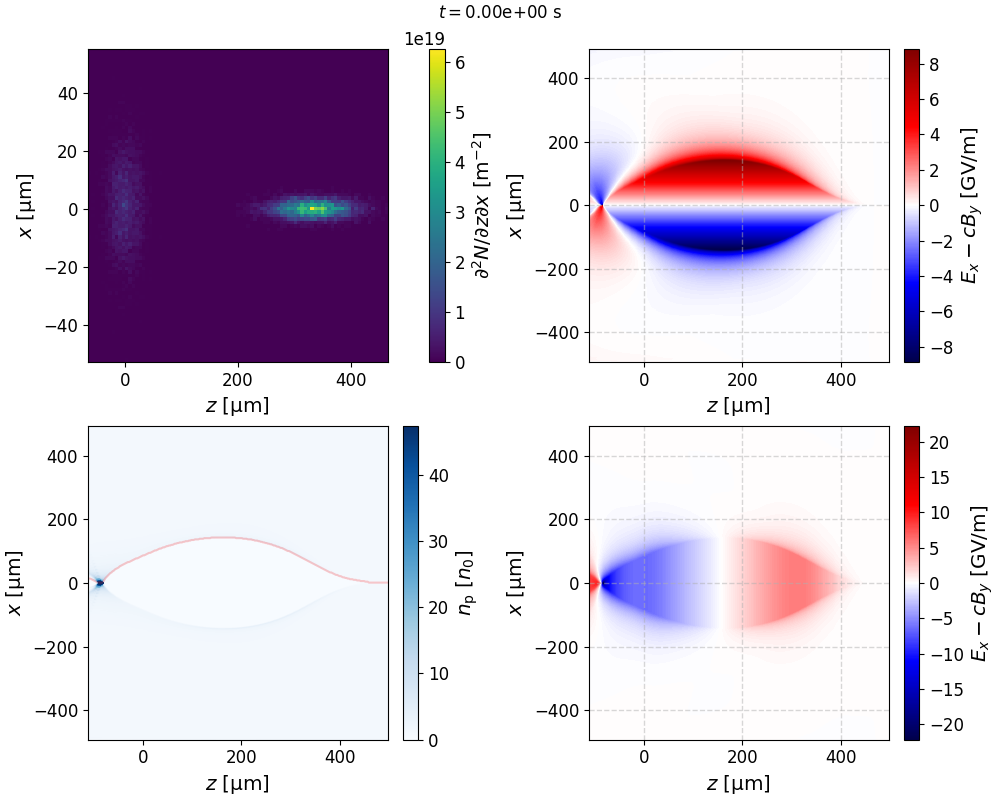

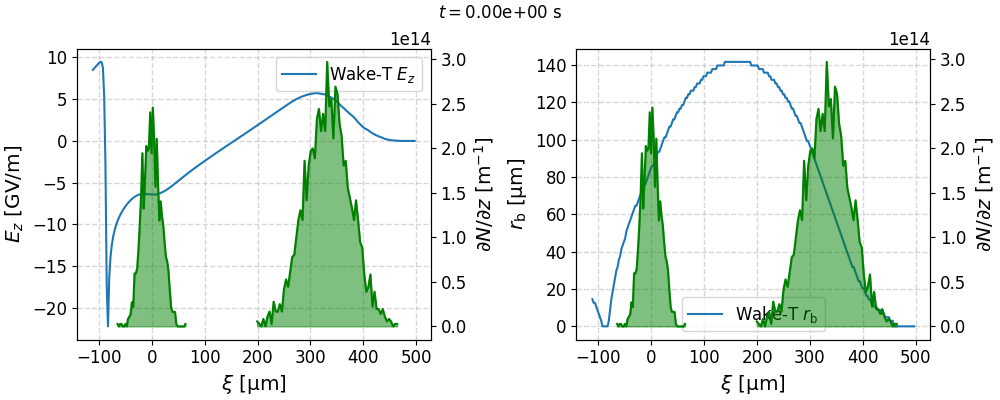

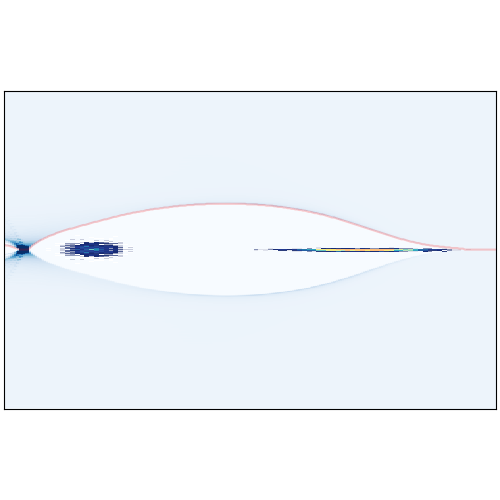

In [8]:
# Close all open figures
#plt.close('all')

# Get slider and figures (requires widget backend for interactive plots)
#ts.slider()

# Labels for plots
zlab = '$z$ [$\mathrm{\mu}$m]'
xilab = r'$\xi$ [$\mathrm{\mu}$m]'
#slab = '$s$ [m]'
xlab = '$x$ [$\mathrm{\mu}$m]'
field_lab = '$E_z$ [GV/m]'
dN_dz_lab = '$\partial N/\partial z$ [$\mathrm{m}^{-1}$]'
#xps_lab = '$x\'$ [mrad]'
#energ_lab = '$\mathcal{E}$ [GeV]'

# Set up a figure with axes
fig_wakeT, axs_wakeT = plt.subplots(nrows=2, ncols=2, layout="constrained", figsize=(10, 4*2))
fig_wakeT.suptitle('$t=$' f'{format(dump_time, ".2e")}' ' s')


# Plot the bunches
w = weights_driver
w = np.append(weights_driver, weights_main)  # The weights for the macroparticles. Append in same order as zs_beams.
nbins = int(np.sqrt(len(w)/2))
hist_bins = [ nbins, nbins ]  # list of 2 ints. Number of bins along each direction, for the histograms
hist_range = [[None, None], [None, None]]
hist_range[0] = [ zs_beams.min(), zs_beams.max() ]  # [m], list contains 2 lists of 2 floats. Extent of the histogram along each direction
hist_range[1] = [ xs_beams.min(), xs_beams.max() ]
extent_beams = hist_range[0] + hist_range[1]
extent_beams = [i*1e6 for i in extent_beams]  # [um]
binned_data, zedges, xedges = np.histogram2d(zs_beams, xs_beams, hist_bins, hist_range, weights=w)
beam_hist2d = binned_data.T/np.diff(zedges)/np.diff(xedges); clab = '$\partial^2 N/\partial z\partial x$ [$\mathrm{m}^{-2}$]'
#beam_hist2d = binned_data.T; clab = '$N(z,x)$'
stage.imshow_plot(beam_hist2d, axes=axs_wakeT[0][0], extent=extent_beams, vmin=None, vmax=None, colmap='viridis', 
                  xlab=zlab, ylab=xlab, clab=clab, gridOn=False, origin='lower', interpolation='nearest')


# Plot the transverse fields
extent = [zs_Ex.min(), zs_Ex.max(), rs_Ex.min(), rs_Ex.max()]
extent = [i*1e6 for i in extent]  # [um]
first_stage.imshow_plot(Ex_cBy/1e9, axes=axs_wakeT[0][1], extent=extent, vmin=Ex_cBy.min()/1e9, vmax=-Ex_cBy.min()/1e9, colmap='seismic', xlab=zlab, ylab=xlab, clab='$E_x-cB_y$ [GV/m]', gridOn=True, origin='lower')


# Plot the plasma number density
cmap_max = np.min(rho)/stage_wakeT.plasma_density/-e*0.0141
cmap_min = np.max(rho)/stage_wakeT.plasma_density/-e
rho_extent = [zs_rho.min(), zs_rho.max(), rs_rho.min(), rs_rho.max()]
rho_extent = [i*1e6 for i in rho_extent]  # [um]
first_stage.imshow_plot(plasma_num_density, axes=axs_wakeT[1][0], extent=rho_extent, vmin=cmap_min, vmax=cmap_max, colmap='Blues', xlab=zlab, ylab=xlab, clab='$n_\mathrm{p}$ [$n_0$]', gridOn=False, origin='lower')
axs_wakeT[1][0].plot(zs_rho*1e6, (bubble_radius_wakeT+main.x_offset)*1e6, 'r', alpha=0.2)


# Plot the longitudinal electric field
extent = [zs_Ez_wakeT.min(), zs_Ez_wakeT.max(), rs_Ez.min(), rs_Ez.max()]
extent = [i*1e6 for i in extent]  # [um]
first_stage.imshow_plot(Ez_wakeT/1e9, axes=axs_wakeT[1][1], extent=extent, vmin=Ez_wakeT.min()/1e9, vmax=-Ez_wakeT.min()/1e9, colmap='seismic', xlab=zlab, ylab=xlab, clab='$E_x-cB_y$ [GV/m]', gridOn=True, origin='lower')


# Set up a figure with axes
fig_wakeT2, axs_wakeT2 = plt.subplots(nrows=1, ncols=2, layout="compressed", figsize=(10, 4))
fig_wakeT2.suptitle('$t=$' f'{format(dump_time, ".2e")}' ' s')


# Plot longitudinal axial E-field
axs_wakeT2[0].plot((zs_Ez_wakeT-c*dump_time)*1e6, Ez_axis_wakeT/1e9, label='Wake-T $E_z$')
axs_wakeT2[0].legend()
axs_wakeT2[0].grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=.5)
axs_wakeT2[0].set_xlabel(xilab)
axs_wakeT2[0].set_ylabel(field_lab)
ax = axs_wakeT2[0].twinx()
ax.fill_between(x=xi_dNdz_main_wakeT*1e6, y1=dNdz_main_wakeT, y2=0, color='g', alpha=0.5)
ax.plot(xi_dNdz_main_wakeT*1e6, dNdz_main_wakeT, 'g')
ax.fill_between(x=xi_dNdz_driver_wakeT*1e6, y1=dNdz_driver_wakeT, y2=0, color='g', alpha=0.5)
ax.plot(xi_dNdz_driver_wakeT*1e6, dNdz_driver_wakeT, 'g')
ax.set_ylabel(dN_dz_lab)


# Plot the plasma bubble radius
axs_wakeT2[1].plot((zs_rho-c*dump_time)*1e6, bubble_radius_wakeT*1e6, label='Wake-T $r_\mathrm{b}$')
axs_wakeT2[1].legend()
axs_wakeT2[1].grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=.5)
axs_wakeT2[1].set_xlabel(xilab)
axs_wakeT2[1].set_ylabel('$r_\mathrm{b}$ [$\mathrm{\mu}$m]')
ax = axs_wakeT2[1].twinx()
ax.fill_between(x=xi_dNdz_main_wakeT*1e6, y1=dNdz_main_wakeT, y2=0, color='g', alpha=0.5)
ax.plot(xi_dNdz_main_wakeT*1e6, dNdz_main_wakeT, 'g')
ax.fill_between(x=xi_dNdz_driver_wakeT*1e6, y1=dNdz_driver_wakeT, y2=0, color='g', alpha=0.5)
ax.plot(xi_dNdz_driver_wakeT*1e6, dNdz_driver_wakeT, 'g')
ax.set_ylabel(dN_dz_lab)


# Plot Beam and plasma
fig_bp, ax_bp = plt.subplots(nrows=1, ncols=1, layout="compressed", figsize=(5, 5))
#cmap = plt.cm.viridis
#cmap.set_bad(color='white')
beam_hist2d[beam_hist2d < 1e1] = np.nan # boolean masking
ax_bp.imshow(plasma_num_density, extent=rho_extent, vmin=0, vmax=20, cmap='Blues', origin='lower', interpolation='nearest', aspect=0.4)
ax_bp.plot(zs_rho*1e6, (bubble_radius_wakeT+main.x_offset)*1e6, 'r', alpha=0.2)
ax_bp.imshow(beam_hist2d, extent=extent_beams, vmin=None, vmax=2.5e19, cmap=cmaps.FLASHForward, origin='lower', interpolation='nearest', aspect=0.4)
ax_bp.set_xlim(rho_extent[0], rho_extent[1])
ax_bp.set_ylim(rho_extent[2], rho_extent[3])
ax_bp.set_yticks([]); ax_bp.set_yticklabels([]); ax_bp.set_xticks([]); ax_bp.set_xticklabels([])
#fig_bp.savefig('Wake-T_beam_plasma.pdf', format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)


#first_stage_wakeT.plot_evolution()
#beam_wakeT.plot_lps()

## Summary of initial beam

In [9]:
_, init_Ez_fit_obj = first_stage.Ez_shift_fit(Ez_axis_wakeT, zs_Ez_wakeT, first_stage.z_slices, main_beam)
first_stage.Ez_fit_obj = init_Ez_fit_obj

first_stage.print_initial_summary(drive_beam, main_beam)

Time step [betatron wavelength/c]:			 0.040
Interstages enabled:					 False
Interstage dipole field:				 0.000
Symmetrised main beam:					 True
Symmetrised drive beam:					 True

Stage length [m]:					 2.500
Plasma density [m^-3]:					 7.000e+21
Drive beam x jitter (std) [um]:				 0.100
Drive beam y jitter (std) [um]:				 0.100
----------------------------------------------------------------------

-------------------------------------------------------------------------------------
Quantity 					 Drive beam 		 Main beam
-------------------------------------------------------------------------------------
Number of macro particles:			 10000			 6000
Initial beam population:			 2.700e+10 		 1.000e+10

Beam centre gradient [GV/m]:				  		 -6.416
Initial mean gamma:				 61154.724 		 9784.731
Initial mean energy [GeV]:			 31.250 		 5.000
Initial rms energy spread [%]:			 0.000 			 0.491

Initial beam x offset [um]:			 -0.068 		 1.205
Initial beam y offset [um]:			 -0.031 			 0.071
Initial b

## Perform tracking

In [10]:
import time

# Start time
start_time = time.time()
cpu_start_time = time.process_time()

# Tracking
linac.run(notebook_name, overwrite=overwrite)

# End time
end_time = time.time()
cpu_end_time = time.process_time()

# Time usage
print('Time taken:', end_time - start_time, 'seconds')
print('CPU seconds:', cpu_end_time - cpu_start_time)

Tracking element 1 (s = 0.0 m, -1.60 nC, 5.0 GeV, SourceBasic, stage 0)
Plasma stage: 100%|█████████████████████████████████████████████| 0.005582/0.005582 m [00:00]


0%:   0%|                                                            | 0/100 [00:00<?, ?it/s][INFO    ] csr.py: module PYFFTW is not installed. Install it to speed up calculation.
[INFO    ] csr.py: module PYFFTW is not installed. Install it to speed up calculation.
[INFO    ] csr.py: module NUMEXPR is not installed. Install it to speed up calculation
[INFO    ] csr.py: module NUMEXPR is not installed. Install it to speed up calculation
Instability tracking 100.03%: 100%|█████████| 100.02960416360263/100 [01:17<00:00,  1.29it/s]


Tracking element 2 (s = 2.5 m, -1.60 nC, 20.8 GeV, StagePrtclTransWakeInstability, stage 1)
Tracking element 3 (s = 2.5 m, -1.60 nC, 20.8 GeV, InterstageNull, stage 1)
Plasma stage: 100%|█████████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.02%: 100%|█████████| 100.01653074931802/100 [01:11<00:00,  1.40it/s]


Tracking element 4 (s = 7.5 m, -1.60 nC, 52.7 GeV, StagePrtclTransWakeInstability, stage 2)
Tracking element 5 (s = 7.5 m, -1.60 nC, 52.7 GeV, InterstageNull, stage 2)
Plasma stage: 100%|█████████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.07%: 100%|█████████| 100.07216393653695/100 [00:44<00:00,  2.24it/s]


Tracking element 6 (s = 12.5 m, -1.60 nC, 85.0 GeV, StagePrtclTransWakeInstability, stage 3)
Tracking element 7 (s = 12.5 m, -1.60 nC, 85.0 GeV, InterstageNull, stage 3)
Plasma stage: 100%|█████████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.01%: 100%|█████████| 100.01206577242489/100 [00:35<00:00,  2.83it/s]


Tracking element 8 (s = 17.5 m, -1.60 nC, 116.9 GeV, StagePrtclTransWakeInstability, stage 4)
Tracking element 9 (s = 17.5 m, -1.60 nC, 116.9 GeV, InterstageNull, stage 4)
Plasma stage: 100%|█████████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.2%: 100%|██████████| 100.20115508401454/100 [00:30<00:00,  3.32it/s]


Tracking element 10 (s = 22.5 m, -1.60 nC, 148.8 GeV, StagePrtclTransWakeInstability, stage 5)
Tracking element 11 (s = 22.5 m, -1.60 nC, 148.8 GeV, InterstageNull, stage 5)
Plasma stage: 100%|█████████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.14%: 100%|█████████| 100.13953063922617/100 [00:26<00:00,  3.75it/s]


Tracking element 12 (s = 27.5 m, -1.59 nC, 180.9 GeV, StagePrtclTransWakeInstability, stage 6)
Tracking element 13 (s = 27.5 m, -1.59 nC, 180.9 GeV, InterstageNull, stage 6)
Plasma stage: 100%|█████████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.21%: 100%|█████████| 100.20509995528445/100 [00:24<00:00,  4.14it/s]


Tracking element 14 (s = 32.5 m, -1.58 nC, 213.0 GeV, StagePrtclTransWakeInstability, stage 7)
Tracking element 15 (s = 32.5 m, -1.58 nC, 213.0 GeV, InterstageNull, stage 7)
Plasma stage: 100%|█████████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.29%: 100%|█████████| 100.28695030190158/100 [00:22<00:00,  4.47it/s]


Tracking element 16 (s = 37.5 m, -1.58 nC, 245.4 GeV, StagePrtclTransWakeInstability, stage 8)
Tracking element 17 (s = 37.5 m, -1.58 nC, 245.4 GeV, InterstageNull, stage 8)
Plasma stage: 100%|█████████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.12%: 100%|██████████| 100.1213712686311/100 [00:20<00:00,  4.81it/s]


Tracking element 18 (s = 42.5 m, -1.58 nC, 276.7 GeV, StagePrtclTransWakeInstability, stage 9)
Tracking element 19 (s = 42.5 m, -1.58 nC, 276.7 GeV, InterstageNull, stage 9)
Plasma stage: 100%|█████████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.33%: 100%|█████████| 100.33026457604284/100 [00:19<00:00,  5.10it/s]


Tracking element 20 (s = 47.5 m, -1.57 nC, 308.7 GeV, StagePrtclTransWakeInstability, stage 10)
Tracking element 21 (s = 47.5 m, -1.57 nC, 308.7 GeV, InterstageNull, stage 10)
Plasma stage: 100%|█████████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.02%: 100%|██████████| 100.0172894698586/100 [00:18<00:00,  5.43it/s]


Tracking element 22 (s = 52.5 m, -1.57 nC, 340.4 GeV, StagePrtclTransWakeInstability, stage 11)
Tracking element 23 (s = 52.5 m, -1.57 nC, 340.4 GeV, InterstageNull, stage 11)
Plasma stage: 100%|█████████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.23%: 100%|█████████| 100.23443632455123/100 [00:17<00:00,  5.71it/s]


Tracking element 24 (s = 57.5 m, -1.57 nC, 372.1 GeV, StagePrtclTransWakeInstability, stage 12)
Tracking element 25 (s = 57.5 m, -1.57 nC, 372.1 GeV, InterstageNull, stage 12)
Plasma stage: 100%|█████████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.17%: 100%|█████████| 100.17117902899022/100 [00:17<00:00,  5.88it/s]


Tracking element 26 (s = 62.5 m, -1.57 nC, 404.0 GeV, StagePrtclTransWakeInstability, stage 13)
Tracking element 27 (s = 62.5 m, -1.57 nC, 404.0 GeV, InterstageNull, stage 13)
Plasma stage: 100%|█████████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.36%: 100%|█████████| 100.36056213038154/100 [00:16<00:00,  6.25it/s]


Tracking element 28 (s = 67.5 m, -1.56 nC, 436.1 GeV, StagePrtclTransWakeInstability, stage 14)
Tracking element 29 (s = 67.5 m, -1.56 nC, 436.1 GeV, InterstageNull, stage 14)
Plasma stage: 100%|█████████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.1%: 100%|██████████| 100.10009819575896/100 [00:15<00:00,  6.49it/s]


Tracking element 30 (s = 72.5 m, -1.56 nC, 467.8 GeV, StagePrtclTransWakeInstability, stage 15)
Tracking element 31 (s = 72.5 m, -1.56 nC, 467.8 GeV, InterstageNull, stage 15)
Plasma stage: 100%|█████████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.22%: 100%|█████████| 100.22147913361583/100 [00:14<00:00,  6.73it/s]


Tracking element 32 (s = 77.5 m, -1.56 nC, 499.6 GeV, StagePrtclTransWakeInstability, stage 16)
Time taken: 483.4003179073334 seconds
CPU seconds: 77.19339500000001


In [11]:
shot_num = 0
stage_num = 15
stage_tracked = linac[shot_num].stages[stage_num]  # Get a specific acceleration stage in a linac. Zero indexing.
beam_out = linac[shot_num].get_beam(stage_num*2+1)  # Get the corresponding beam after the acceleration stage. Zero indexing.
#beam_out = linac[shot_num].get_beam(-2)

## Plot outputs

### Cut-out bubble radius, longitudinal E-field and longitudinal beam profile

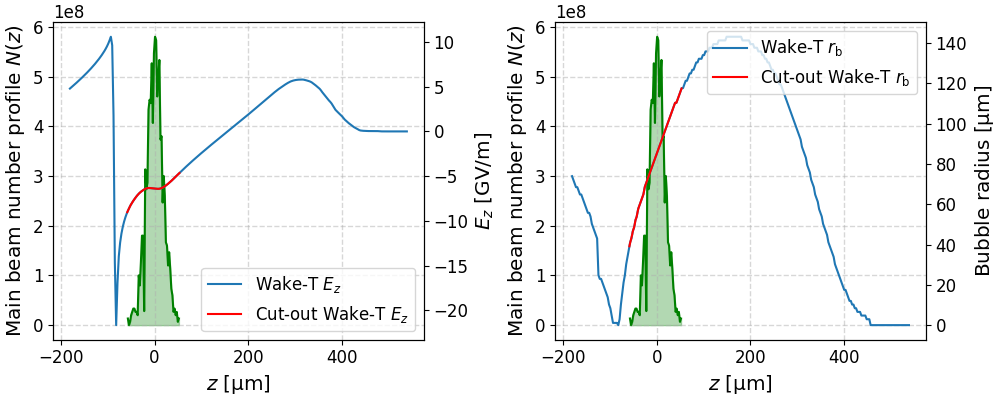

In [12]:
stage_tracked.plot_Ez_rb_cut()

# Save the figure
if save_plots is True:
    if use_interstages is True and overwrite is True:
        filename = stage_tracked.diag_path + 'Ez_rb_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt'
    else:
        filename = stage_tracked.diag_path + 'Ez_rb_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt'
    plt.savefig(filename+'.pdf', format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)
    plt.savefig(filename+'.png', format='png', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

### Beam slice plots

In [13]:
#stage_tracked.slice_offset_s_diag(beam=beam_out)

In [14]:
#stage_tracked.centroid_snapshot_plots(beam=beam_out)

### Beam particle plots

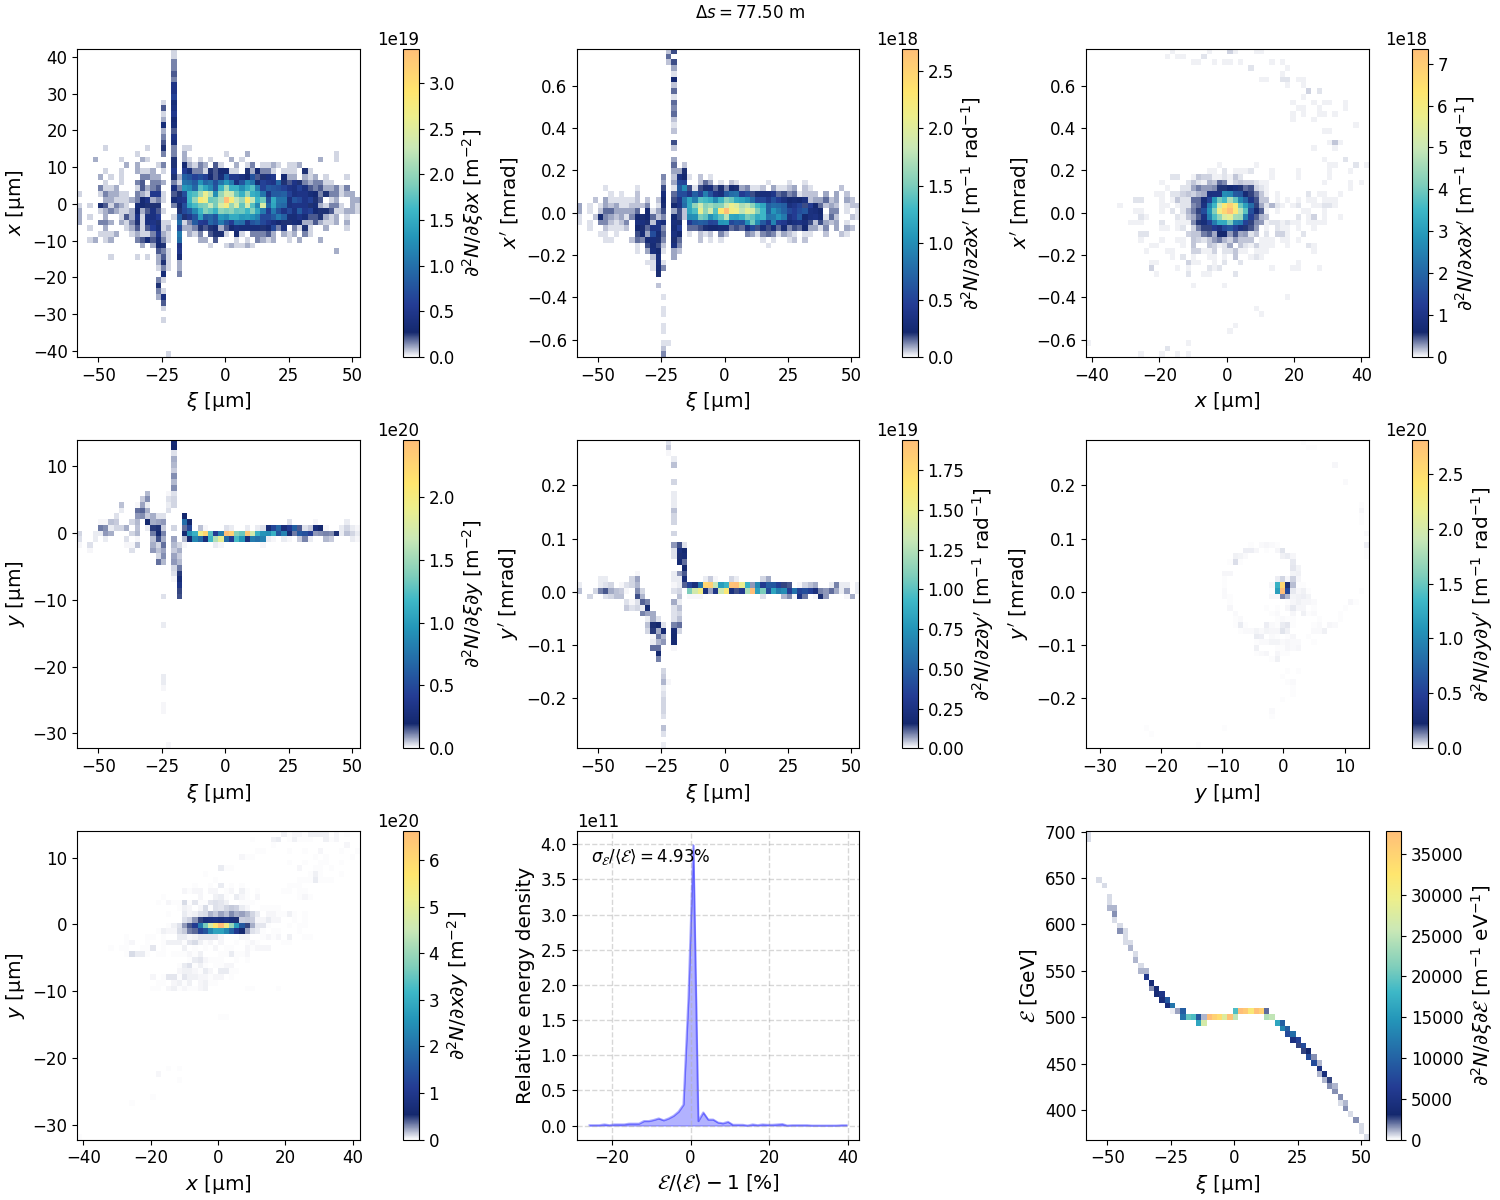

In [15]:
plot_stage = stage_tracked

# Set up override to plot other stages
#plot_stage = linac[shot_num].stages[1]  # Get a specific acceleration stage in a linac. Zero indexing.

plot_stage.density_map_diags(beam=beam_out, plot_centroids=False)

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'densMaps_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt'
    else:
        filename = stage_tracked.diag_path + 'densMaps_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt'
    plt.savefig(filename+'.pdf', format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)
    plt.savefig(filename+'.png', format='png', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

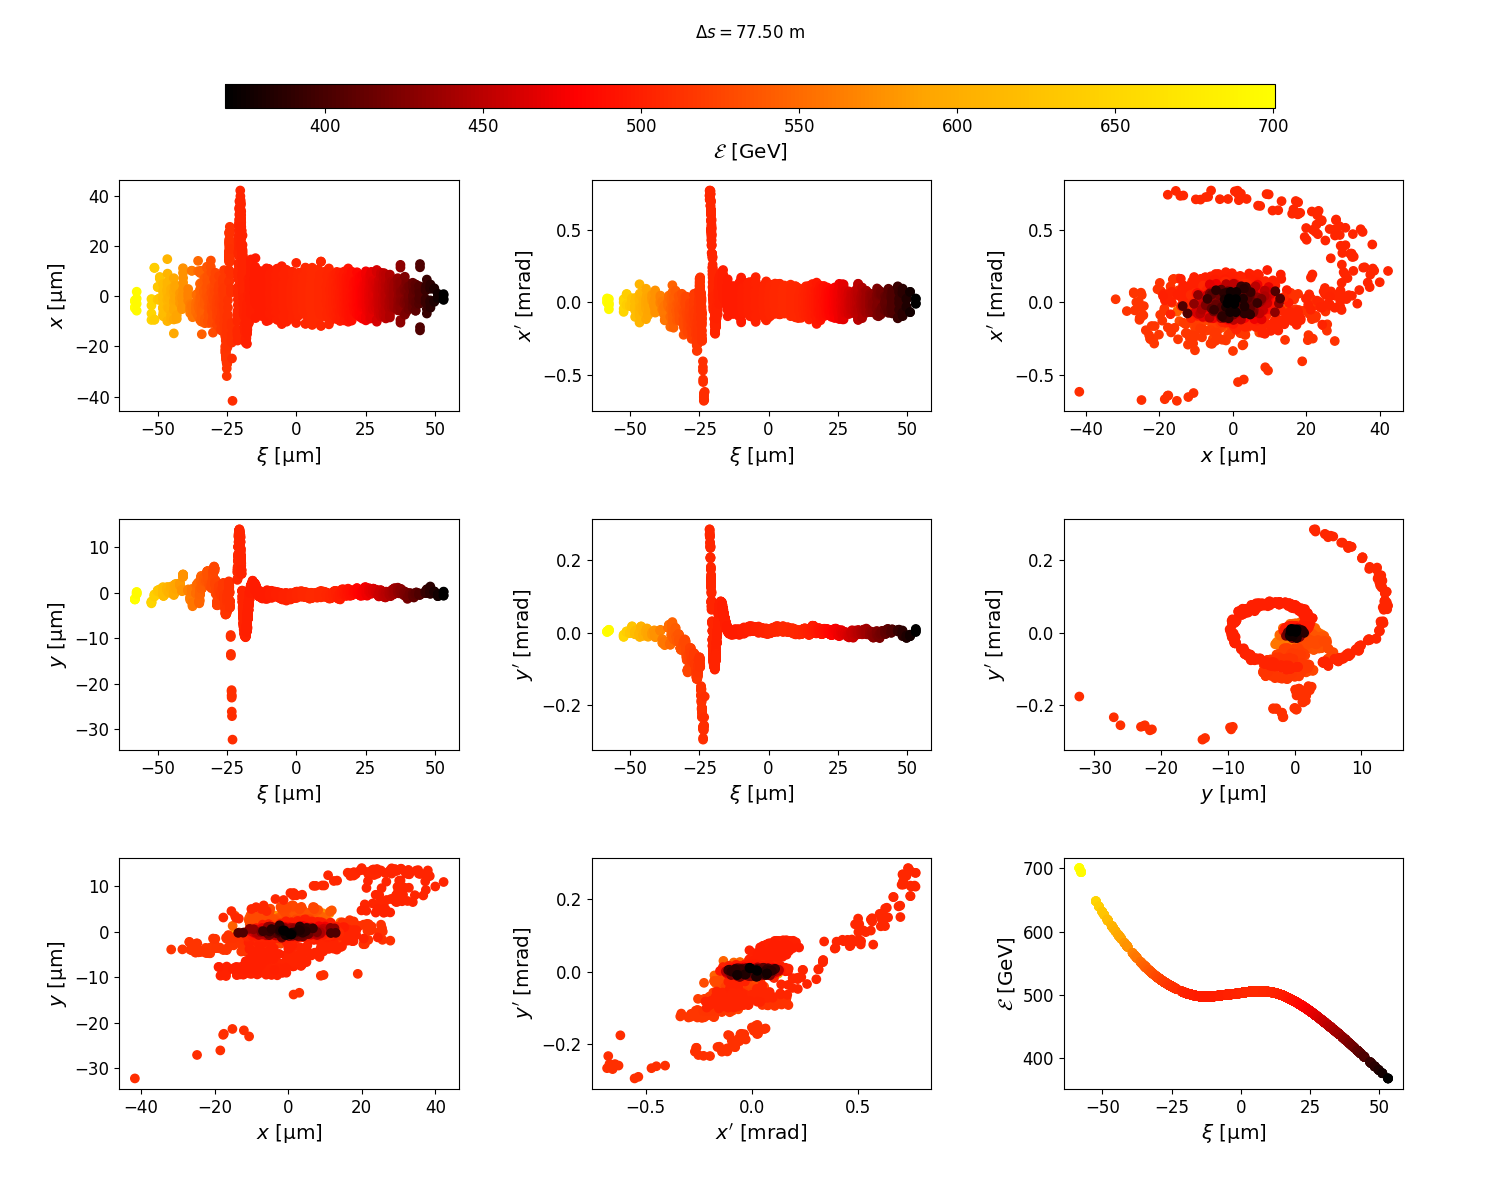

In [16]:
plot_stage = stage_tracked

# Set up override to plot other stages
#plot_stage = linac[shot_num].stages[1]  # Get a specific acceleration stage in a linac. Zero indexing.

plot_stage.scatter_diags(beam=beam_out, plot_centroids=False, n_th_particle=1, show_slice_grid=False, plot_k_beta=False)

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'scatter_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.png'
    else:
        filename = stage_tracked.diag_path + 'scatter_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.png'
    plt.savefig(filename, format='png', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

## Plot beam evolution and survey

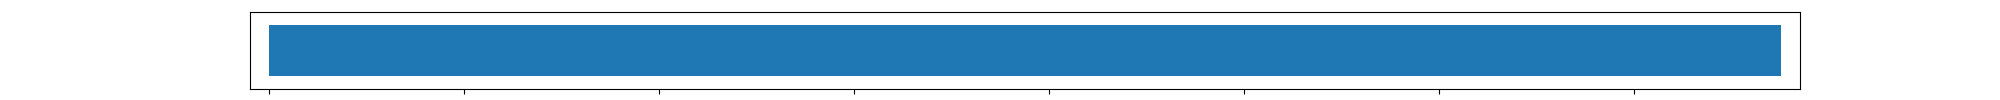

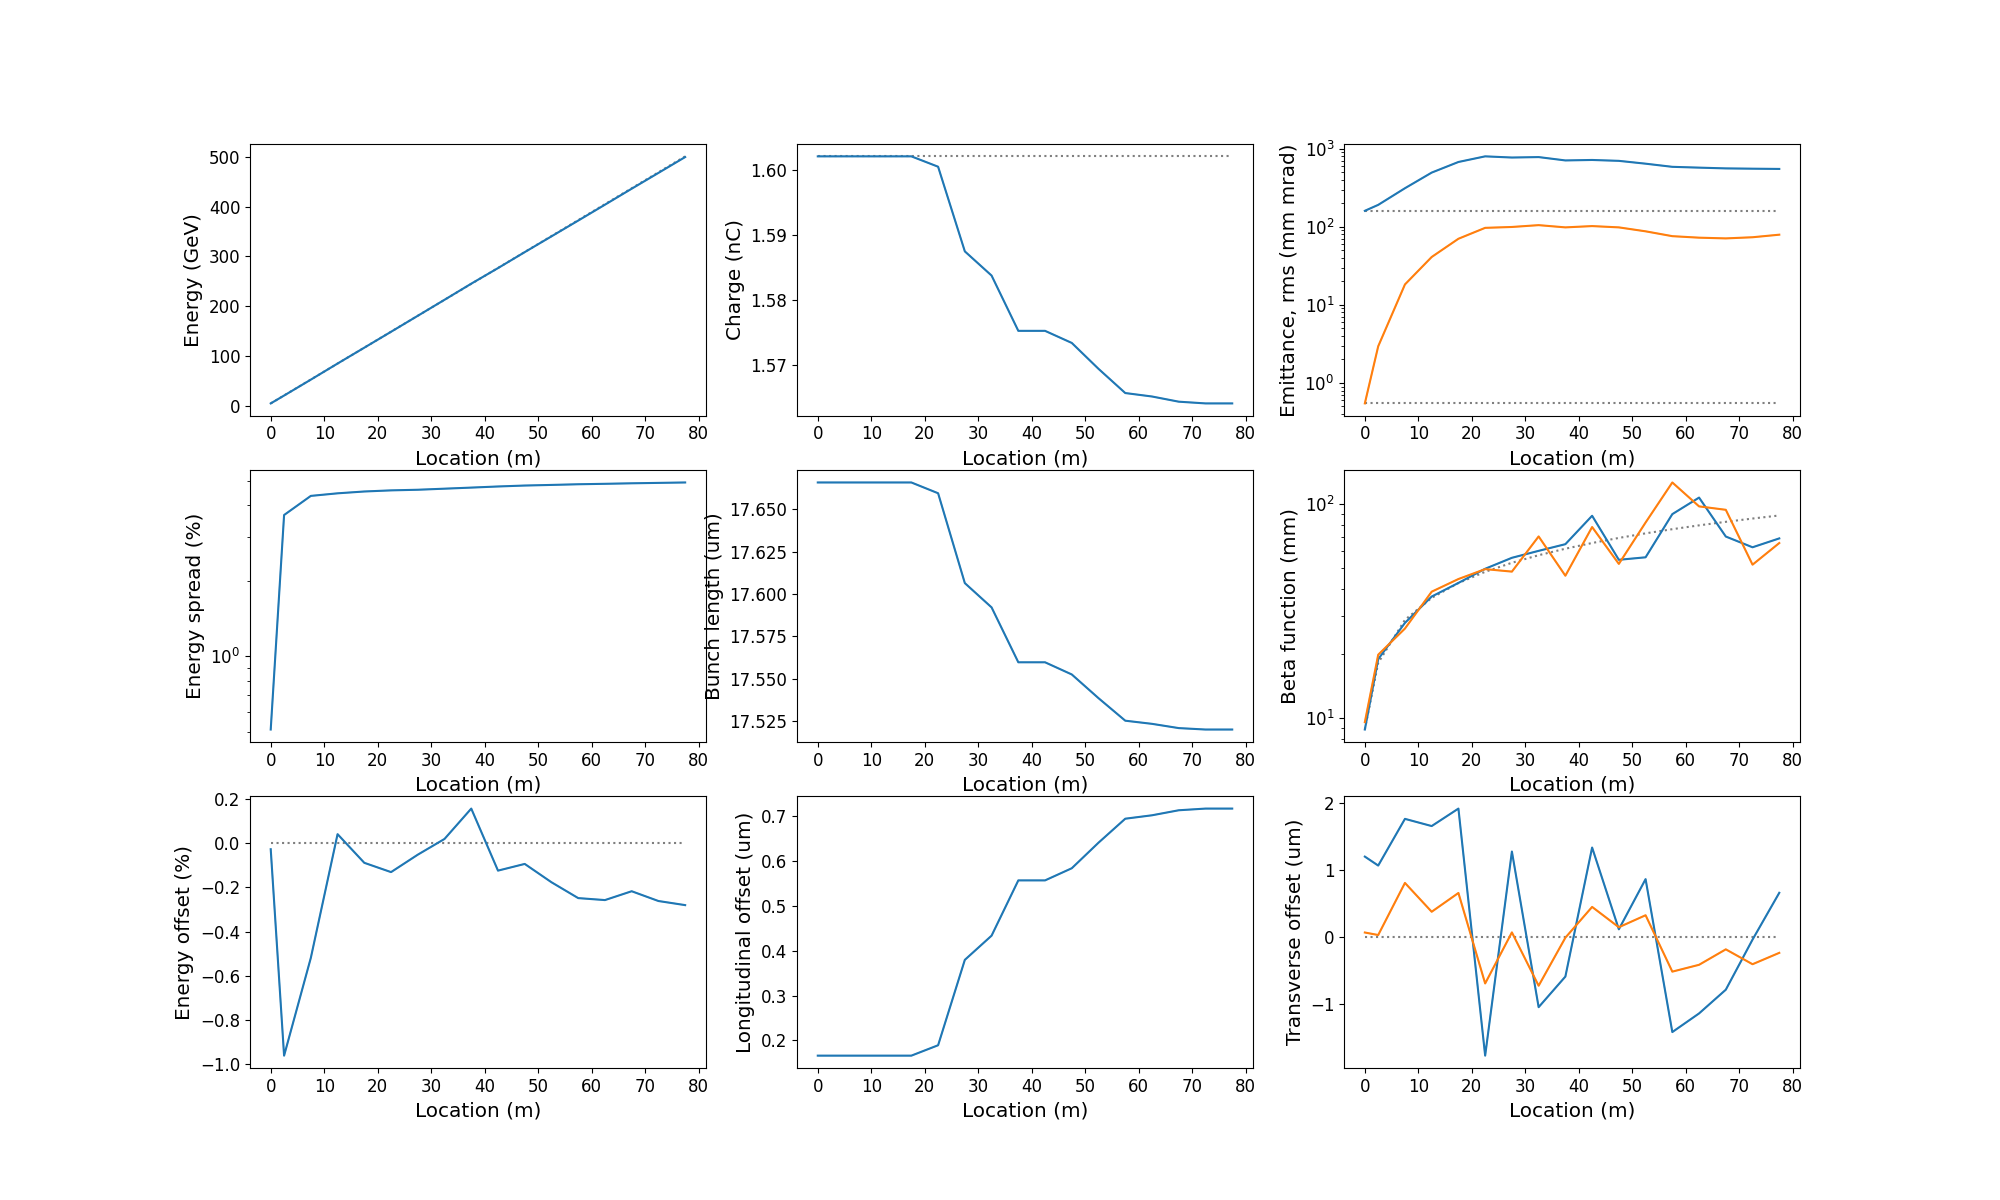

In [17]:
# plot linac survey
linac.plot_survey()

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'sketch_HALHF_' + str(num_stages) + 'prtclInstabilityStages_interstages'
    else:
        filename = stage_tracked.diag_path + 'sketch_HALHF_' + str(num_stages) + 'prtclInstabilityStages'
    plt.savefig(filename+'.pdf', format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)
    plt.savefig(filename+'.png', format='png', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)


# plot beam evolution
linac.plot_evolution()

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'evolution_HALHF_' + str(num_stages) + 'prtclInstabilityStages_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt'
    else:
        filename = stage_tracked.diag_path + 'evolution_HALHF_' + str(num_stages) + 'prtclInstabilityStages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt'
    plt.savefig(filename+'.pdf', format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)
    plt.savefig(filename+'.png', format='png', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

In [18]:
#stage_tracked = linac[shot_num].stages[stage_num]  # Get a specific acceleration stage in a linac. Zero indexing.
#beam_out = linac[shot_num].get_beam(stage_num*2+1)  # Get the corresponding beam after the acceleration stage. Zero indexing.

stage_tracked.print_current_summary(stage_tracked.drive_beam, linac.initial_beam(), beam_out)

Time step [betatron wavelength/c]:	 0.040
Interstages enabled:			 False
Interstage dipole field:		 0.000
Symmetrised main beam:			 True
Symmetrised drive beam:			 True

Stage length [m]:			 5.000
Propagation length [m]:			 77.500
Plasma density [m^-3]:			 7.000e+21
Drive beam x jitter (std) [um]:		 0.100
Drive beam y jitter (std) [um]:		 0.100
---------------------------------------------------

-------------------------------------------------------------------------------------
Quantity 					 Drive beam 		 Main beam
-------------------------------------------------------------------------------------
Initial number of macro particles:		 10000			 6000
Current number of macro particles:		  			 5857
Initial beam population:			 2.700e+10 		 1.000e+10
Current beam population:			 	 		 9.762e+09

Beam centre gradient [GV/m]:				  		 -6.390
Current mean gamma:				 	 		 977686.694
Initial mean energy [GeV]:			 31.250 		 4.999
Current mean energy [GeV]:			 	 		 499.597
Initial rms energy sprea

In [19]:
if overwrite is True:
    linac.animate_lps()
    linac.animate_phasespace_x()
    linac.animate_phasespace_y()
    linac.animate_sideview_x()
    linac.animate_sideview_y()

## Isolate some plots for saving

In [20]:
ss, vals_mean, vals_std, stage_nums = linac.evolution_fcn([Beam.abs_charge, \
                                             Beam.energy, Beam.rel_energy_spread, \
                                             Beam.bunch_length, Beam.z_offset, \
                                             Beam.norm_emittance_x, Beam.norm_emittance_y, \
                                             Beam.beta_x, Beam.beta_y, \
                                             Beam.x_offset, Beam.y_offset])


# mean values
Qs = vals_mean[:,0]
mean_Es = vals_mean[:,1]
sigdeltas = vals_mean[:,2]
#sigzs = vals_mean[:,3]
z0s = vals_mean[:,4]
emnxs = vals_mean[:,5]
emnys = vals_mean[:,6]
betaxs = vals_mean[:,7]
betays = vals_mean[:,8]
x0s = vals_mean[:,9]
y0s = vals_mean[:,10]

# nominal energies
Es_nom = linac.nom_stage_energies()

# Set default font sizes for figures
params = {
    #'figure.figsize': (15, 5),
    'axes.titlesize': 'xx-large',
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14
}
pylab.rcParams.update(params)

# Set default Latex fonts
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
#plt.rcParams['text.latex.preamble'] = r'\usepackage{mathrsfs}'
#plt.rcParams['text.latex.preamble'] = r'\usepackage{siunitx}'

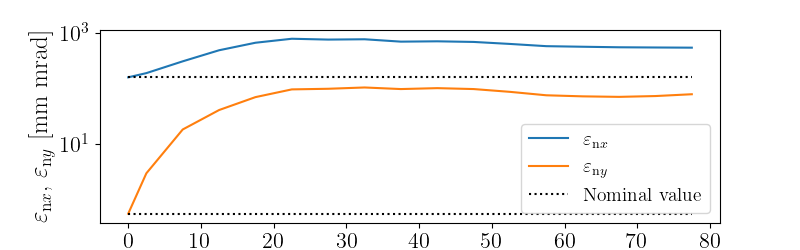

In [21]:
fig, ax= plt.subplots(figsize=(8, 2.5))

# Normalised emittances vs. s
ax.plot(ss, emnxs*1e6, label=r'$\varepsilon_{\mathrm{n}x}$')
ax.plot(ss, emnys*1e6, label=r'$\varepsilon_{\mathrm{n}y}$')
ax.plot(ss, np.ones(len(ss))*emnxs[0]*1e6, 'k:', label='Nominal value')
ax.plot(ss, np.ones(len(ss))*emnys[0]*1e6, 'k:')
ax.set_yscale('log')
#ax.set_ylabel('Norm. emitt. [mm mrad]', fontsize=14)
ax.set_ylabel(r'$\varepsilon_{\mathrm{n}x}$, $\varepsilon_{\mathrm{n}y}$ [mm mrad]', fontsize=18)
ax.set_xlabel('$s$ [m]')
#ax.legend(loc='right', fontsize=14)
ax.legend(fontsize=14)
#fig.savefig('norm_emitt_vs_s.pdf', format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'norm_emitt_vs_s_' + str(num_stages) + 'prtclInstabilityStages_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'norm_emitt_vs_s_' + str(num_stages) + 'prtclInstabilityStages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

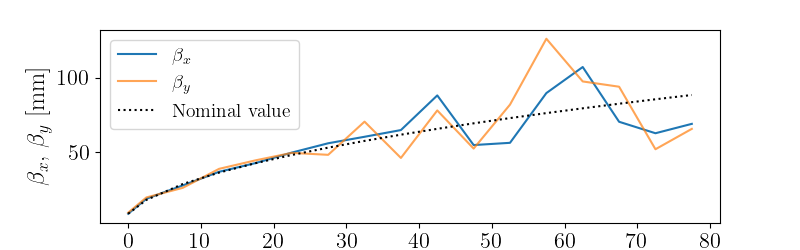

In [22]:
fig, ax = plt.subplots(figsize=(8, 2.5))

# Beta functions vs. s
ax.plot(ss, betaxs*1e3, label=r'$\beta_{x}$')
ax.plot(ss, betays*1e3, label=r'$\beta_{y}$', alpha=0.7)
ax.plot(ss, np.sqrt(Es_nom/Es_nom[0])*betaxs[0]*1e3, 'k:', label='Nominal value')
#ax.set_yscale('log')
#ax.set_ylabel('Beta function [mm]')
ax.set_ylabel(r'$\beta_{x}$, $\beta_{y}$ [mm]')
ax.set_xlabel('$s$ [m]')
ax.legend(fontsize=14)

#ax_twin = ax.twinx()
#ax_twin.plot(ss, Qs*1e9, 'r', label='Charge')
#ax_twin.set_ylabel('Charge [nC]')
#
## Gather the legends of both axes and display them together
#lines1, labels1 = ax.get_legend_handles_labels()
#lines2, labels2 = ax_twin.get_legend_handles_labels()
#lines = lines1 + lines2
#labels = labels1 + labels2
#
#ax.legend(lines, labels)
#ax.legend(lines, labels, loc='lower right')

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'beta_func_vs_s_' + str(num_stages) + 'prtclInstabilityStages_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'beta_func_vs_s_' + str(num_stages) + 'prtclInstabilityStages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

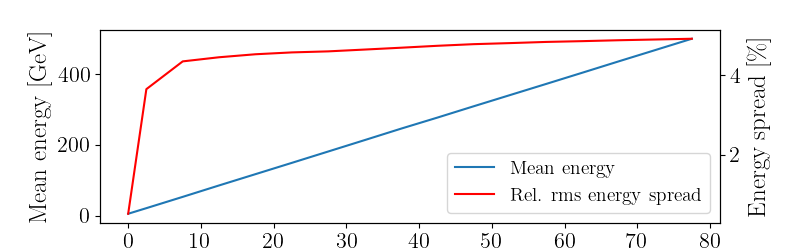

In [23]:
fig, ax = plt.subplots(figsize=(8, 2.5))

# Energy and energy spread functions vs. s
#ax.plot(ss, mean_Es/1e9, label='$\mathcal{E}$')
ax.plot(ss, mean_Es/1e9, label='Mean energy')
ax_twin = ax.twinx()
#ax_twin.plot(ss, sigdeltas*1e2, 'r', label='$\sigma_\mathcal{E}/\mathcal{E}$')
ax_twin.plot(ss, sigdeltas*1e2, 'r', label='Rel. rms energy spread')

#ax.set_yscale('log')
ax.set_ylabel('Mean energy [GeV]')
ax_twin.set_ylabel(r'Energy spread [\%]')
ax.set_xlabel('$s$ [m]')

# Gather the legends of both axes and display them together
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax_twin.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax.legend(lines, labels, fontsize=14, loc='lower right')
# Set the facecolor of the plot box to be opaque
#fig.patch.set_facecolor('none')
#fig.patch.set_alpha(0.0)
#ax.patch.set_facecolor('none')
#ax.patch.set_alpha(1.0)

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'energy_energy_spread_vs_s_' + str(num_stages) + 'prtclInstabilityStages_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'energy_energy_spread_vs_s_' + str(num_stages) + 'prtclInstabilityStages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

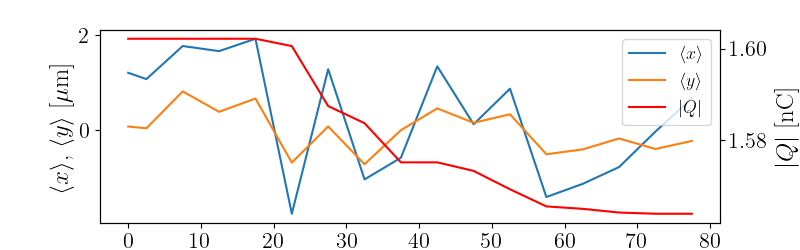

In [24]:
fig, ax = plt.subplots(figsize=(8, 2.5))

# Mean transverse offsets vs. s
ax.plot(ss, x0s*1e6, label=r'$\langle x \rangle$')
ax.plot(ss, y0s*1e6, label=r'$\langle y \rangle$')
#ax.plot(ss, np.zeros(len(ss)), 'k:', label='Nominal value')
#ax.set_yscale('log')
#ax.set_ylabel('Trans. offset [$\mathrm{\mu}$m]')
ax.set_ylabel(r'$\langle x \rangle$, $\langle y \rangle$ [$\mathrm{\mu}$m]')
ax.set_xlabel('$s$ [m]')
#ax.legend(loc='upper right')

ax_twin = ax.twinx()
ax_twin.plot(ss, Qs*1e9, 'r', label='$|Q|$')
ax_twin.set_ylabel('$|Q|$ [nC]')
ax.set_xlabel('$s$ [m]')

# Gather the legends of both axes and display them together
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax_twin.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2

ax.legend(lines, labels, fontsize=13)

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'tr_offset_vs_s_' + str(num_stages) + 'prtclInstabilityStages_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'tr_offset_vs_s_' + str(num_stages) + 'prtclInstabilityStages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

In [25]:
# Customised colour map
#colors = ['white', 'mediumblue', 'aquamarine', 'limegreen', 'yellow', 'orangered']
#colors = ['white', 'mediumblue', 'darkcyan', 'aquamarine', 'lightgreen', 'mediumseagreen', 'green']
#colors = ['white', 'forestgreen', 'limegreen', 'lawngreen', 'aquamarine', 'deepskyblue']
#colors = ['white', 'forestgreen', 'lawngreen', 'aquamarine', 'deepskyblue', 'royalblue']
#colors = ['white', 'seagreen', 'green', 'springgreen', 'yellow', 'orangered']
#bounds = [0, 0.2, 0.4, 0.8, 1]
#cmap = LinearSegmentedColormap.from_list('my_cmap', colors, N=256)


import abel.utilities.colors as cmaps
cmap = cmaps.FLASHForward

# Labels for plots
ylab = '$y$ [$\mathrm{\mu}$m]'
xps_lab = '$x\'$ [mrad]'
yps_lab = '$y\'$ [mrad]'
energ_lab = '$\mathcal{E}$ [GeV]'

# Macro particles data
zs = beam_out.zs()
xs = beam_out.xs()
xps = beam_out.xps()
ys = beam_out.ys()
yps = beam_out.yps()
Es = beam_out.Es()
weights = beam_out.weightings()

nbins = int(np.sqrt(len(weights)/2))
hist_bins = [ nbins, nbins ]  # list of 2 ints. Number of bins along each direction, for the histograms

# Set default font sizes for figures
densMap_params = {
    'figure.figsize': (6, 5),
    'axes.labelsize': 20,
    'xtick.labelsize': 17,
    'ytick.labelsize': 17,
    'legend.fontsize': 14
}
pylab.rcParams.update(densMap_params)

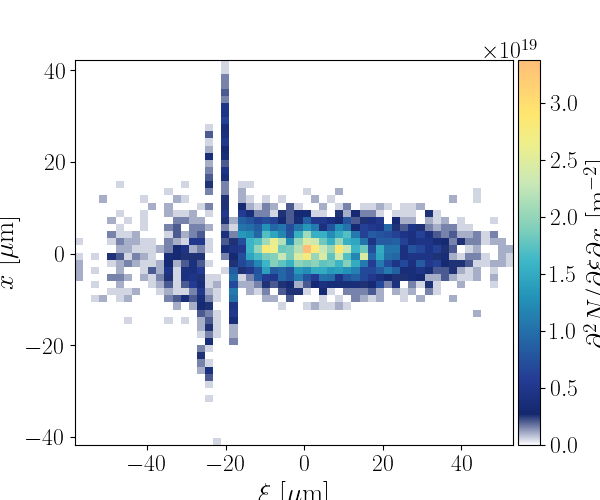

In [26]:
# 2D z-x distribution
fig, ax = plt.subplots()
hist_range = [[None, None], [None, None]]
hist_range[0] = [ zs.min(), zs.max() ]  # [m], list contains 2 lists of 2 floats. Extent of the histogram along each direction
hist_range[1] = [ xs.min(), xs.max() ]
extent_zx = hist_range[0] + hist_range[1]
extent_zx = [i*1e6 for i in extent_zx]  # [um]
stage_tracked.distribution_plot_2D(arr1=zs, arr2=xs, weights=weights, hist_bins=hist_bins, hist_range=hist_range, axes=ax, extent=extent_zx, vmin=None, vmax=None, colmap=cmap, xlab=xilab, ylab=xlab, clab=r'$\partial^2 N/\partial\xi \partial x$ [$\mathrm{m}^{-2}$]', origin='lower', interpolation='nearest', reduce_cax_pad=True)

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'densMap_xi_x_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'densMap_xi_x_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

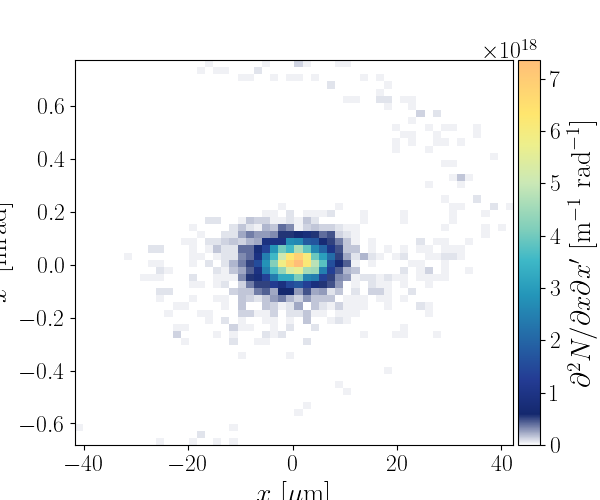

In [27]:
# 2D z-x' distribution
fig, ax = plt.subplots()
hist_range_xxp = [[None, None], [None, None]]
hist_range_xxp[0] = hist_range[1]
hist_range_xxp[1] = [ xps.min(), xps.max() ]  # [rad]
extent_xxp = hist_range_xxp[0] + hist_range_xxp[1]
extent_xxp[0] = extent_xxp[0]*1e6  # [um]
extent_xxp[1] = extent_xxp[1]*1e6  # [um]
extent_xxp[2] = extent_xxp[2]*1e3  # [mrad]
extent_xxp[3] = extent_xxp[3]*1e3  # [mrad]
stage_tracked.distribution_plot_2D(arr1=xs, arr2=xps, weights=weights, hist_bins=hist_bins, hist_range=hist_range_xxp, axes=ax, extent=extent_xxp, vmin=None, vmax=None, colmap=cmap, xlab=xlab, ylab=xps_lab, clab='$\partial^2 N/\partial x\partial x\'$ [$\mathrm{m}^{-1}$ $\mathrm{rad}^{-1}$]', origin='lower', interpolation='nearest', reduce_cax_pad=True)

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'densMap_x_xp_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'densMap_x_xp_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

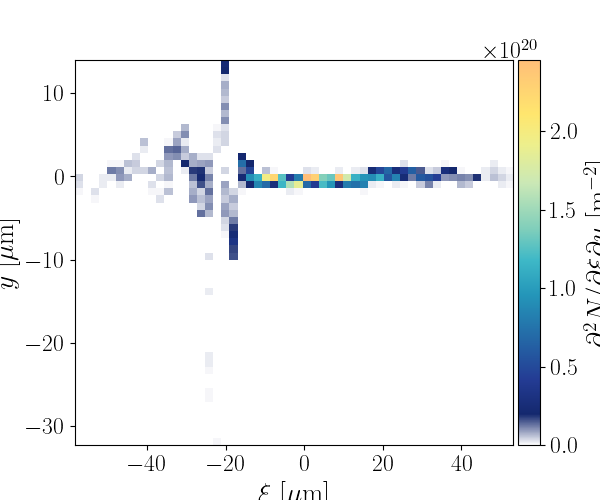

In [28]:
# 2D z-y distribution
fig, ax = plt.subplots()
hist_range_zy = [[None, None], [None, None]]
hist_range_zy[0] = hist_range[0]
hist_range_zy[1] = [ ys.min(), ys.max() ]
extent_zy = hist_range_zy[0] + hist_range_zy[1]
extent_zy = [i*1e6 for i in extent_zy]  # [um]
stage_tracked.distribution_plot_2D(arr1=zs, arr2=ys, weights=weights, hist_bins=hist_bins, hist_range=hist_range_zy, axes=ax, extent=extent_zy, vmin=None, vmax=None, colmap=cmap, xlab=xilab, ylab=ylab, clab=r'$\partial^2 N/\partial\xi \partial y$ [$\mathrm{m}^{-2}$]', origin='lower', interpolation='nearest', reduce_cax_pad=True)

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'densMap_xi_y_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'densMap_xi_y_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

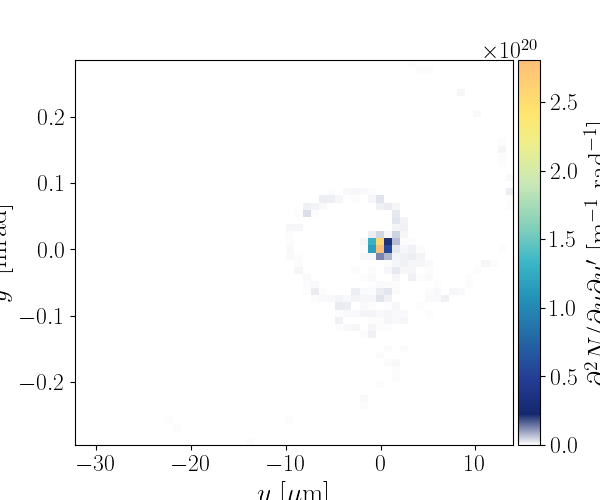

In [29]:
# 2D y-y' distribution
fig, ax = plt.subplots()
hist_range_yyp = [[None, None], [None, None]]
hist_range_yyp[0] = hist_range_zy[1]
hist_range_yyp[1] = [ yps.min(), yps.max() ]  # [rad]
extent_yyp = hist_range_yyp[0] + hist_range_yyp[1]
extent_yyp[0] = extent_yyp[0]*1e6  # [um]
extent_yyp[1] = extent_yyp[1]*1e6  # [um]
extent_yyp[2] = extent_yyp[2]*1e3  # [mrad]
extent_yyp[3] = extent_yyp[3]*1e3  # [mrad]
stage_tracked.distribution_plot_2D(arr1=ys, arr2=yps, weights=weights, hist_bins=hist_bins, hist_range=hist_range_yyp, axes=ax, extent=extent_yyp, vmin=None, vmax=None, colmap=cmap, xlab=ylab, ylab=yps_lab, clab='$\partial^2 N/\partial y\partial y\'$ [$\mathrm{m}^{-1}$ $\mathrm{rad}^{-1}$]', origin='lower', interpolation='nearest', reduce_cax_pad=True)

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'densMap_y_yp_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'densMap_y_yp_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

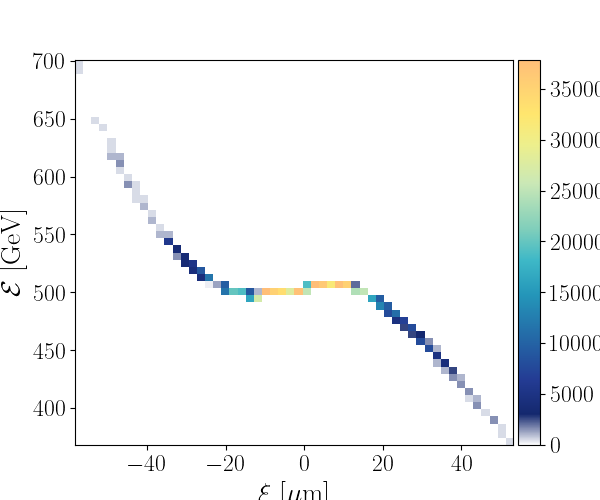

In [30]:
# 2D z-energy distribution
fig, ax = plt.subplots()
hist_range_energ = [[None, None], [None, None]]
hist_range_energ[0] = hist_range[0]
hist_range_energ[1] = [ Es.min(), Es.max() ]  # [eV]
extent_energ = hist_range_energ[0] + hist_range_energ[1]
extent_energ[0] = extent_energ[0]*1e6  # [um]
extent_energ[1] = extent_energ[1]*1e6  # [um]
extent_energ[2] = extent_energ[2]/1e9  # [GeV]
extent_energ[3] = extent_energ[3]/1e9  # [GeV]
stage_tracked.distribution_plot_2D(arr1=zs, arr2=Es, weights=weights, hist_bins=hist_bins, hist_range=hist_range_energ, axes=ax, extent=extent_energ, vmin=None, vmax=None, colmap=cmap, xlab=xilab, ylab=energ_lab, clab=r'$\partial^2 N/\partial \xi \partial\mathcal{E}$ [$\mathrm{m}^{-1}$ $\mathrm{eV}^{-1}$]', origin='lower', interpolation='nearest', reduce_cax_pad=True)

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'densMap_xi_energy_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'densMap_xi_energy_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

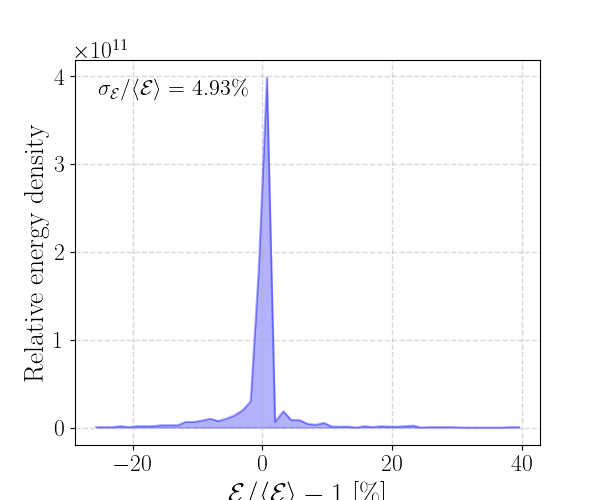

In [31]:
# Energy distribution
fig, ax = plt.subplots()
dN_dE, rel_energ = beam_out.rel_energy_spectrum()
dN_dE = dN_dE/-e
ax.fill_between(rel_energ*100, y1=dN_dE, y2=0, color='b', alpha=0.3)
ax.plot(rel_energ*100, dN_dE, color='b', alpha=0.3, label='Relative energy density')
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=.5)
ax.set_xlabel(r'$\mathcal{E}/\langle\mathcal{E}\rangle-1$ [\%]')
ax.set_ylabel('Relative energy density')
# Add text to the plot
ax.text(0.05, 0.95, r'$\sigma_\mathcal{E}/\langle\mathcal{E}\rangle=$ ' f'{format(beam_out.rel_energy_spread()*100, ".2f")}' '\%', fontsize=16, color='black', ha='left', va='top', transform=ax.transAxes)

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'rel_energy_density_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'rel_energy_density_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

## Save the code in the settings and inputs cells to a file

In [32]:
if overwrite is True:

    import nbformat
    
    # Read the Jupyter Notebook file
    notebook_path = current_dir + path_sep + notebook_name + '.ipynb'
    with open(notebook_path, 'r', encoding='utf-8') as notebook_file:
        notebook_content = nbformat.read(notebook_file, as_version=4)
    
    # Extract codes for the settings and definitions
    cell_number = 5  # Replace with the appropriate cell number
    cell = notebook_content['cells'][cell_number]
    if cell.cell_type == 'code':
        settings_str = ''.join(cell['source'])
        #print(code_as_string)
    
    # Extract codes defining the sources
    cell_number = 7
    cell = notebook_content['cells'][cell_number]
    if cell.cell_type == 'code':
        sources_str = ''.join(cell['source'])
    
    # Extract codes defining the linac
    cell_number = 9
    cell = notebook_content['cells'][cell_number]
    if cell.cell_type == 'code':
        linac_str = ''.join(cell['source'])
    
    code_as_string = '##############################\n' + '# Settings and definitions\n' + '##############################\n\n' + settings_str \
    + '\n\n\n\n##############################\n' + '# Define the input beams\n' + '##############################\n\n' + sources_str \
    + '\n\n\n\n##############################\n' + '# Define the linac\n' + '##############################\n\n' + linac_str
    
    # Open the file for writing and write the code
    file_path = diag_path + 'inputs.py'
    with open(file_path, 'w', encoding='utf-8') as output_file:
        output_file.write(code_as_string)
    # File is automatically closed when you exit this block
    
    print(f'Code has been saved to {file_path}')

Code has been saved to /Users/ben_c/Library/CloudStorage/OneDrive-UniversitetetiOslo/ABEL/examples/run_data/HALHF_prtcl_instability_stage_tests/inputs.py


## Scrap code

/var/folders/5z/cp2xdj_d2931049r_hb7qng00000gn/T/ipykernel_9441/3229043526.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


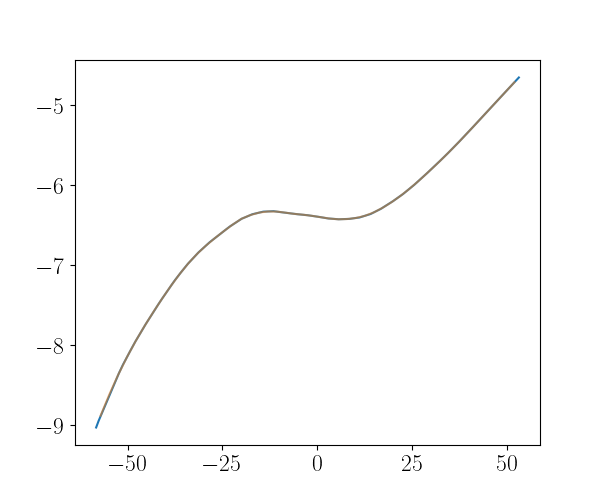

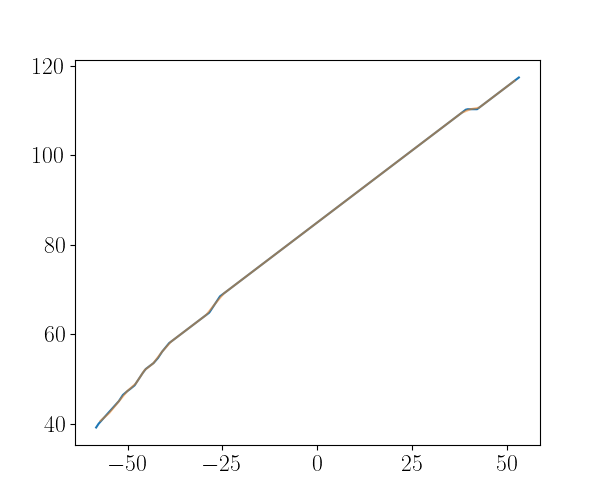

In [33]:
indices = np.argsort(beam_out.zs())
zs = beam_out.zs()
zs_sorted = zs[indices]

_, Ez_fit = stage_tracked.Ez_shift_fit(stage_tracked.Ez_axial, stage_tracked.zs_Ez_axial, stage_tracked.z_slices, beam_out)
plt.figure()
plt.plot(zs_sorted*1e6, Ez_fit(zs_sorted)/1e9)
plt.plot(stage_tracked.z_slices*1e6, stage_tracked.Ez_roi/1e9, alpha=0.5)

_, rb_fit = stage_tracked.rb_shift_fit(stage_tracked.bubble_radius_axial, stage_tracked.zs_bubble_radius_axial, stage_tracked.z_slices, beam_out)
plt.figure()
plt.plot(zs_sorted*1e6, rb_fit(zs_sorted)*1e6)
plt.plot(stage_tracked.z_slices*1e6, stage_tracked.bubble_radius_roi*1e6, alpha=0.5)

TypeError: text() missing 2 required positional arguments: 'y' and 's'

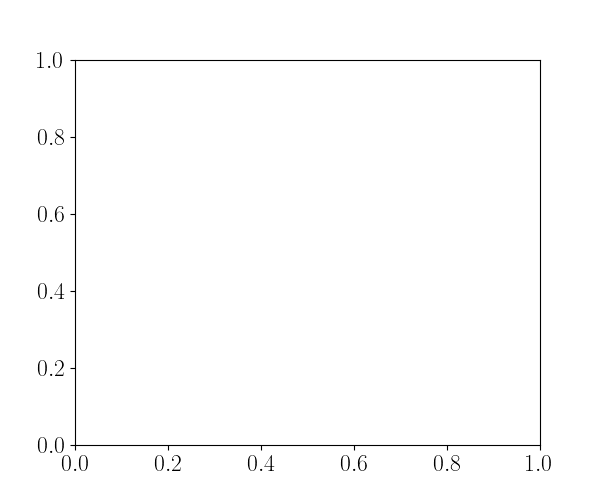

In [34]:
#import matplotlib.pyplot as plt

#plt.rc('text', usetex=True)
##plt.rc('font', family='BOONDOX-calo')
#plt.rc('font', family='BOONDOX-cal')
#plt.rc('font', family='calligra')
#plt.rcParams['font.family'] = 'BOONDOX-calo'

##plt.text(0.5, 0.5, r'$\mathcal{BOONDOX}$', fontsize=24)
#ax.text(0.5, 0.5, r'$E = mc^2$', fontname='Ecolier_court', size=36, ha='center', va='center')
#

# Use Boondox calligraphic font for math mode
#plt.rc('text', usetex=True)
#plt.rc('text.latex', preamble=r'\usepackage{boondox-calo}')



fig, ax = plt.subplots()
#ax.set_title(r'$E = mc^2$')
#ax.set_xlabel(r'$\mathcal{E} = mc^2$')
plt.text(r'$\mathcal{E} = mc^2$')
##ax.set_xlabel(r'$\mathscr{E} = mc^2$')
##ax.set_ylabel(r'$\mathcalboondox{E} = mc^2$')
#ax.set_ylabel(r'$\mathcalboondox{E} = mc^2$')
#
#plt.show()



#plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = r'\usepackage{mathrsfs}'
#plt.text(0.5, 0.5, r'$\mathscr{E}$', fontsize=24)
#plt.show()


#plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = r'\usepackage{unicode-math}'
##plt.rcParams['text.latex.preamble'] = r'\DeclareFontFamily{U}{calligra}{}'
#plt.text(0.5, 0.5, r'$\mathscr{E}$', fontsize=24)
#plt.show()

#plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = r'\usepackage{unicode-math}\setmathfont{xits-math.otf}'
#plt.text(0.5, 0.5, r'$\mathscr{E}$', fontsize=24)
#plt.show()



In [ ]:
#%whos

In [ ]:
my_array = [5,4,3,2,1]
my_array = np.flip(my_array)
print(my_array)
#for i in range(len(my_array)-2, -1, -1):
#    print(my_array[i])

bla=0
bla += np.cumsum(my_array)
print(np.cumsum(my_array))
print(bla)
np.insert(bla[1:],0,0)